# Week 6: kNN

First, import your libraries!

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

## Data prep

Based on the following data summary, what questions and business metric should we use? 

In [3]:
bank_data = pd.read_csv("https://raw.githubusercontent.com/UVADS/DS-3001/main/data/bank.csv")
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43628 non-null  int64 
 1   job        43628 non-null  object
 2   marital    43628 non-null  object
 3   education  43628 non-null  object
 4   default    43628 non-null  object
 5   balance    43628 non-null  int64 
 6   housing    43628 non-null  object
 7   contact    43628 non-null  object
 8   duration   43628 non-null  int64 
 9   campaign   43628 non-null  int64 
 10  pdays      43628 non-null  int64 
 11  previous   43628 non-null  int64 
 12  poutcome   43628 non-null  object
 13  signed up  43628 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 4.7+ MB


< your answer here >

Now, let's check the composition of the data.

In [4]:
bank_data.marital.value_counts()   # 3 levels

married     26241
single      12355
divorced     5032
Name: marital, dtype: int64

In [5]:
bank_data.education.value_counts()   # 4 levels

secondary    22404
tertiary     12863
primary       6584
unknown       1777
Name: education, dtype: int64

In [6]:
bank_data.default.value_counts()   # 2 levels

no     42844
yes      784
Name: default, dtype: int64

In [7]:
bank_data.job.value_counts()   # 12 levels! What should we do?

blue-collar      9366
management       9142
technician       7321
admin.           5001
services         4010
retired          2184
self-employed    1530
entrepreneur     1433
unemployed       1259
housemaid        1199
student           907
unknown           276
Name: job, dtype: int64

In [8]:
bank_data.contact.value_counts()   # 3 levels -- difference between cellular and telephone?

cellular     28295
unknown      12523
telephone     2810
Name: contact, dtype: int64

In [9]:
bank_data.housing.value_counts()   # 2 levels

yes    24231
no     19397
Name: housing, dtype: int64

In [10]:
bank_data.poutcome.value_counts()   # 4 levels

unknown    35684
failure     4723
other       1783
success     1438
Name: poutcome, dtype: int64

In [11]:
bank_data['signed up'].value_counts()   # 2 levels

0    38554
1     5074
Name: signed up, dtype: int64

We should collapse the variable with 12 levels. In Python, this process is slightly different than it is in R.

In [12]:
employed = ['admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
           'self-employed', 'services', 'technician']
# unemployed = ['student', 'unemployed', 'unknown']
bank_data.job = bank_data.job.apply(lambda x: "Employed" if x in employed else "Unemployed")
bank_data.job.value_counts()

Employed      34001
Unemployed     9627
Name: job, dtype: int64

Now, we convert the appropriate columns to factors.

In [13]:
# bank_data.info()   # check the variables
cat = ['job', 'marital', 'education', 'default', 'housing', 'contact',
      'poutcome', 'signed up']   # select the columns to convert
bank_data[cat] = bank_data[cat].astype('category')
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        43628 non-null  int64   
 1   job        43628 non-null  category
 2   marital    43628 non-null  category
 3   education  43628 non-null  category
 4   default    43628 non-null  category
 5   balance    43628 non-null  int64   
 6   housing    43628 non-null  category
 7   contact    43628 non-null  category
 8   duration   43628 non-null  int64   
 9   campaign   43628 non-null  int64   
 10  pdays      43628 non-null  int64   
 11  previous   43628 non-null  int64   
 12  poutcome   43628 non-null  category
 13  signed up  43628 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.3 MB


### Check for missing data

R uses the mice package, which allows you to visualize the NaNs in a dataset and later impute it. There is no equivalent package in Python, but we can still complete the same steps.

Using the seaborn package, we can see the distribution of missing values. Along the x-axis, you will see the proportion of the data missing for that variable.

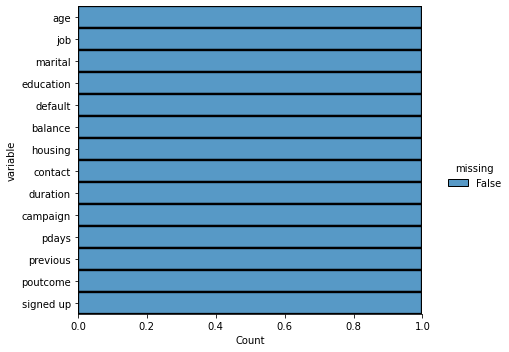

In [14]:
import seaborn as sns
sns.displot(
    data=bank_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
# plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)
# the above line will same the image to your computer!

**No missing data!!**

Next, we normalize the numeric variables.

In [15]:
numeric_cols = bank_data.select_dtypes(include='int64').columns
print(numeric_cols)

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')


In [16]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(bank_data[numeric_cols])   # conduct data transformation
scaled_df = pd.DataFrame(d, columns=numeric_cols)   # convert back to pd df; transformation converts to array
bank_data[numeric_cols] = scaled_df   # put data back into the main df

In [17]:
bank_data.describe()   # as we can see, the data is now normalized!

age       balance      duration      campaign         pdays  \
count  43628.000000  43628.000000  43628.000000  43628.000000  43628.000000   
mean       0.297630      0.085120      0.052513      0.028516      0.047116   
std        0.137894      0.027623      0.052539      0.050099      0.114633   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.194805      0.073448      0.020943      0.000000      0.000000   
50%        0.272727      0.076853      0.036600      0.016129      0.000000   
75%        0.389610      0.085714      0.064864      0.032258      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

           previous  
count  43628.000000  
mean       0.002110  
std        0.008443  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

Now, we onehot encode the data -- for reference, this is the process of converting categorical variables to a usable form for a machine learning algorithm.

In [18]:
cat_cols = bank_data.select_dtypes(include='category').columns
print(cat_cols)

Index(['job', 'marital', 'education', 'default', 'housing', 'contact',
       'poutcome', 'signed up'],
      dtype='object')


In [19]:
encoded = pd.get_dummies(bank_data[cat_cols])
encoded.head()   # note the new columns

job_Employed  job_Unemployed  marital_divorced  marital_married  \
0             1               0                 0                1   
1             0               1                 0                1   
2             1               0                 0                1   
3             1               0                 0                1   
4             1               0                 0                1   

   marital_single  education_primary  education_secondary  education_tertiary  \
0               0                  0                    0                   1   
1               0                  1                    0                   0   
2               0                  0                    0                   1   
3               0                  0                    1                   0   
4               0                  0                    0                   1   

   education_unknown  default_no  ...  housing_yes  contact_cellular  \
0                  0           1  ...            0                 0   
1                  0           1  ...            0                 1   
2                  0           1  ...            0                 1   
3                  0           1  ...            0                 0   
4                  0           1  ...            0                 1   

   contact_telephone  contact_unknown  poutcome_failure  poutcome_other  \
0                  0                1                 0               0   
1                  0                0                 0               0   
2                  0                0                 0               0   
3                  0                1                 0               0   
4                  0                0                 0               0   

   poutcome_success  poutcome_unknown  signed up_0  signed up_1  
0                 0                 1            1            0  
1                 1                 0            1            0  
2                 0                 1            1            0  
3                 0                 1            1            0  
4                 0                 1            1            0  

[5 rows x 22 columns]

In [20]:
bank_data = bank_data.drop(cat_cols, axis=1)

In [21]:
bank_data = bank_data.join(encoded)

In [22]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43628 entries, 0 to 43627
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  43628 non-null  float64
 1   balance              43628 non-null  float64
 2   duration             43628 non-null  float64
 3   campaign             43628 non-null  float64
 4   pdays                43628 non-null  float64
 5   previous             43628 non-null  float64
 6   job_Employed         43628 non-null  uint8  
 7   job_Unemployed       43628 non-null  uint8  
 8   marital_divorced     43628 non-null  uint8  
 9   marital_married      43628 non-null  uint8  
 10  marital_single       43628 non-null  uint8  
 11  education_primary    43628 non-null  uint8  
 12  education_secondary  43628 non-null  uint8  
 13  education_tertiary   43628 non-null  uint8  
 14  education_unknown    43628 non-null  uint8  
 15  default_no           43628 non-null 

The data is ready! Now, let's build our model.

## Train model

We'll run the kNN algorithm on the banking data. First, we'll check the prevalence of the target class.

In [23]:
bank_data['signed up_1'].value_counts()[1] / bank_data['signed up_1'].count()

0.11630145777940772

This means that at random, we have an 11.6% chance of correctly picking a subscribed individual. Let's see if kNN can do any better.

In [24]:
"""
X = bank_data.drop(['signed up_1'], axis=1).values   # independent variables
y = bank_data['signed up_1'].values                  # dependent variable
"""

train, test = train_test_split(bank_data,  test_size=0.4, stratify = bank_data['signed up_1']) 

In [25]:
test, val = train_test_split(test, test_size=0.5, stratify=test['signed up_1'])

Now, let's train the classifier for k=9.

In [26]:
import random
random.seed(1984)   # kNN is a random algorithm, so we use `random.seed(x)` to make results repeatable

X_train = train.drop(['signed up_1'], axis=1).values
y_train = train['signed up_1'].values

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [27]:
# now, we check the model's accuracy on the test data:

X_test = test.drop(['signed up_1'], axis=1).values
y_test = test['signed up_1'].values

neigh.score(X_test, y_test)

0.9903735961494384

In [28]:
# now, we test the accuracy on our validation data.

X_val = val.drop(['signed up_1'], axis=1).values
y_val = val['signed up_1'].values

neigh.score(X_val, y_val)

0.9919779967911987

## Evaluate model

A 99.0% accuracy rate is pretty good but keep in mind the baserate is roughly 89/11, so we have more or less a 90% chance of guessing right if we don't know anything about the customer, but the negative outcomes we don't really care about, this models value is being able to id sign ups when they are actually sign ups. This requires us to know are true positive rate, or Sensitivity or Recall. So let's dig a little deeper.   

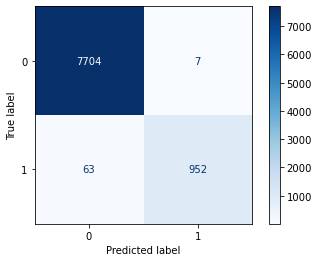

In [29]:
# create a confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(neigh, X_val, y_val, cmap='Blues')  
plt.show()

*tip: use this link to change the color scheme of your confusion matrix: https://matplotlib.org/stable/tutorials/colors/colormaps.html*

In [30]:
# create classification report
from sklearn.metrics import classification_report

y_val_pred = neigh.predict(X_val)

In [31]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7767
           1       0.94      0.99      0.96       959

    accuracy                           0.99      8726
   macro avg       0.97      0.99      0.98      8726
weighted avg       0.99      0.99      0.99      8726



In [32]:
# we didn't get sensitivity and specificity, so we'll calculate that ourselves.
sensitivity = 943/(943+72)   # = TP/(TP+FN)
specificity = 7707/(7707+4)   # = TN/(TN+FP)
print(sensitivity, specificity)

0.929064039408867 0.9994812605368953


#### Selecting the correct 'k'

How does "k" affect classification accuracy? Let's create a function to calculate classification accuracy based on the number of "k."

In [33]:
def chooseK(k, X_train, y_train, X_test, y_test):
    random.seed(1)
    print("calculating... ", k, "k")    # I'll include this so you can see the progress of the function as it runs
    class_knn = KNeighborsClassifier(n_neighbors=k)
    class_knn.fit(X_train, y_train)
    
    # calculate accuracy
    accu = class_knn.score(X_test, y_test)
    return accu

We'll test odd k values from 1 to 21. We want to create a table of all the data, so we'll use list comprehension to create the "accuracy" column. 

*remember: Python is end-exclusive; we want UP to 21 to we'll have to extend the end bound to include it*

In [34]:
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(x, X_train, y_train, X_test, y_test) for x in list(range(1, 22, 2))]})

calculating...  1 k
calculating...  3 k
calculating...  5 k
calculating...  7 k
calculating...  9 k
calculating...  11 k
calculating...  13 k
calculating...  15 k
calculating...  17 k
calculating...  19 k
calculating...  21 k


In [35]:
test

k      accu
0    1  0.997593
1    3  0.994614
2    5  0.993353
3    7  0.991176
4    9  0.990374
5   11  0.988082
6   13  0.985217
7   15  0.984300
8   17  0.982925
9   19  0.981320
10  21  0.980403

In [36]:
test = test.sort_values(by=['accu'], ascending=False)
test

k      accu
0    1  0.997593
1    3  0.994614
2    5  0.993353
3    7  0.991176
4    9  0.990374
5   11  0.988082
6   13  0.985217
7   15  0.984300
8   17  0.982925
9   19  0.981320
10  21  0.980403

**From here, we see that the best value of k=1!**

Let's go through the code we wrote in a bit more detail, specifically regarding the DataFrame construction.

For reference, here's the line of code we wrote:
```
test = pd.DataFrame({'k':list(range(1,22,2)), 
                     'accu':[chooseK(x, X_train, y_train, X_test, y_test) for x in list(range(1, 22, 2))]})
```

pandas DataFrames wrap around the Python dictionary data type, which is identifiable by the use of curly brackets ({}) and key-value pairs. The keys correspond to the column names (i.e. 'k' or 'accu') while the values are a list comprised of all the values we want to include. 

For 'k', we made a list of the range of numbers from 1 to 22 (end exclusive), selecting only every *other* value. This is done using the syntax: `range(first_val, end_val, by=?)`. Having no `by=` value means that we select every value in that range.

For 'accu', we used <a href=https://www.w3schools.com/python/python_lists_comprehension.asp>list comprehension</a>, which boils down to being loop shorthand with the output being entered into a list. We could easily re-write the code as:

```
temp = []
for x in list(range(1, 22, 2)):
    temp.append(chooseK(x, X_train, y_train, X_test, y_test))
```

before adding the list to the DataFrame. Evidently, the list comprehension saves time and memory, which is why we used it earlier.

#### Now, let's graph our results!

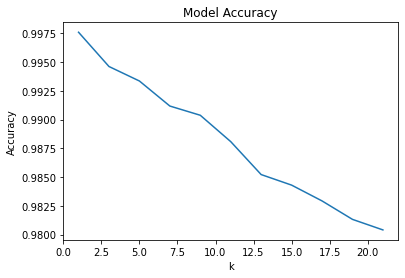

In [37]:
plt.plot(test['k'], test['accu'])
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

## Adjusting the threshold

In [38]:
# we want to make a table containing: probability, expected, and actual values

test_probs = neigh.predict_proba(X_test)
test_preds = neigh.predict(X_test)

In [39]:
# convert probabilities to pd df
test_probabilities = pd.DataFrame(test_probs, columns = ['not_signed_up_prob', 'signed_up_prob'])
test_probabilities

not_signed_up_prob  signed_up_prob
0                    1.0             0.0
1                    1.0             0.0
2                    1.0             0.0
3                    1.0             0.0
4                    1.0             0.0
...                  ...             ...
8721                 1.0             0.0
8722                 1.0             0.0
8723                 1.0             0.0
8724                 0.0             1.0
8725                 0.0             1.0

[8726 rows x 2 columns]

In [40]:
final_model = pd.DataFrame({'actual_class': y_test.tolist(),
                           'pred_class': test_preds.tolist(),
                           'pred_prob': [test_probabilities['signed_up_prob'][i] if test_preds[i]==1 else test_probabilities['not_signed_up_prob'][i] for i in range(len(test_preds))]})
# that last line is some list comprehension -- to understand that here in particular click the following link:
# https://stackoverflow.com/questions/4260280/if-else-in-a-list-comprehension

In [41]:
final_model.head()

actual_class  pred_class  pred_prob
0             0           0        1.0
1             0           0        1.0
2             0           0        1.0
3             0           0        1.0
4             0           0        1.0

In [42]:
# add a column about the probability the observation is in the positive class
final_model['pos_pred'] = [final_model.pred_prob[i] if final_model.pred_class[i]==1 else 1-final_model.pred_prob[i] for i in range(len(final_model.pred_class))]

In [43]:
final_model.head()

actual_class  pred_class  pred_prob  pos_pred
0             0           0        1.0       0.0
1             0           0        1.0       0.0
2             0           0        1.0       0.0
3             0           0        1.0       0.0
4             0           0        1.0       0.0

In [44]:
# convert classes to categories
final_model.actual_class = final_model.actual_class.astype('category')
final_model.pred_class = final_model.pred_class.astype('category')

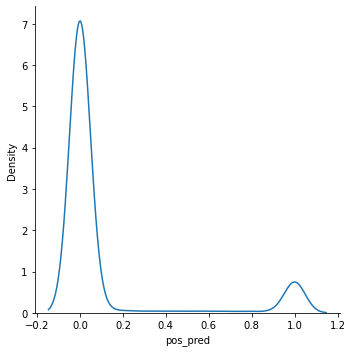

In [45]:
# create probability distribution graph
import seaborn as sns

sns.displot(final_model, x="pos_pred", kind="kde")

In [46]:
final_model.pos_pred.value_counts()

0.000000    7563
1.000000     799
0.111111      91
0.222222      49
0.555556      40
0.333333      40
0.444444      38
0.777778      37
0.666667      37
0.888889      32
Name: pos_pred, dtype: int64

In most datasets, the probabilities range between 0 and 1, causing uncertain predictions. A threshold must be set for where you consider the prediction to actually be a part of the positive class. Is a 60% certainty positive? How about 40%? This is where you have more control over your model's classifications. **This is especially useful for reducing incorrect classifications that you may have noticed in your confusion matrix.**

In [47]:
from sklearn.metrics import confusion_matrix

def adjust_thres(x, y, z):
    """
    x=pred_probabilities
    y=threshold
    z=tune_outcome
    """
    thres = pd.DataFrame({'new_preds': [1 if i > y else 0 for i in x]})
    thres.new_preds = thres.new_preds.astype('category')
    con_mat = confusion_matrix(z, thres)  
    print(con_mat)

In [48]:
confusion_matrix(final_model.actual_class, final_model.pred_class)   # original model

array([[7704,    7],
       [  77,  938]])

In [49]:
adjust_thres(final_model.pos_pred, .90, final_model.actual_class)   # raise threshold 

[[7711    0]
 [ 216  799]]


In [50]:
adjust_thres(final_model.pos_pred, .3, final_model.actual_class)   # lower threshold

[[7664   47]
 [  39  976]]


## More for next week: evaluation metrics

#### ROC/AUC curve
There are a few really cool graphing options, so I'll show you a few. There are several packages in Python are interactive as well!

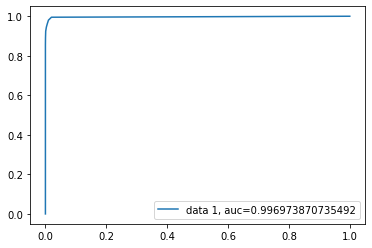

In [51]:
# basic graph
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test, final_model.pos_pred)
auc = metrics.roc_auc_score(y_test, final_model.pos_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [52]:
# installs dependency for next graph
! pip install plot_metric

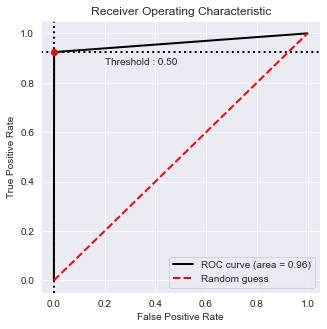

In [53]:
# a pretty cool one

from plot_metric.functions import BinaryClassification

# Visualisation with plot_metric
bc = BinaryClassification(y_test, final_model.pred_class, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

#### F1 score

In [54]:
metrics.f1_score(y_test, final_model.pred_class)

0.9571428571428572

#### LogLoss

In [55]:
metrics.log_loss(y_test, final_model.pred_class)

0.3324848515189683

## Another quick example

In [56]:
from pydataset import data

iris = data("iris")
iris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [57]:
iris.describe()

Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

In [58]:
from sklearn.preprocessing import scale

cols = list(iris.columns[:4])

scaledIris = pd.DataFrame(scale(iris.iloc[:, :4]), index=iris.index, columns=cols)

In [59]:
scaledIris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
dtypes: float64(4)
memory usage: 5.9 KB


In [60]:
scaledIris['Species'] = iris['Species']

In [61]:
# split datasets
irisTrain, irisTest = train_test_split(scaledIris,  test_size=0.4, stratify = scaledIris['Species']) 
irisTest, irisVal = train_test_split(irisTest, test_size=0.5, stratify = irisTest['Species'])

In [62]:
Xi_train = irisTrain.drop(['Species'], axis=1)
yi_train = irisTrain['Species']

Xi_test = irisTest.drop(['Species'], axis=1)
yi_test = irisTest['Species']

Xi_val = irisVal.drop(['Species'], axis=1)
yi_val = irisVal['Species']

In [63]:
iris_neigh = KNeighborsClassifier(n_neighbors=3)
iris_neigh.fit(Xi_train, yi_train)

KNeighborsClassifier(n_neighbors=3)

In [64]:
iris_neigh.score(Xi_test, yi_test)

0.9666666666666667

In [65]:
iris_neigh.score(Xi_val, yi_val)

0.9

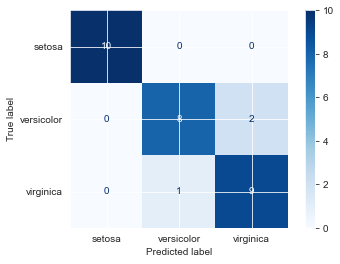

In [66]:
plot_confusion_matrix(iris_neigh, Xi_val, yi_val, cmap='Blues')  
plt.show()

## Example using 10-k cross-validation 

In [67]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=12) 

X_si = scaledIris.drop(['Species'], axis=1)
y_si = scaledIris['Species']

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

cv_neigh = KNeighborsClassifier(n_neighbors=3)   # create classifier
scores = cross_val_score(cv_neigh, X_si, y_si, scoring='accuracy', cv=rkf, n_jobs=-1)   # do repeated cv

print('Accuracy: %.3f (%.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.949 (0.061)


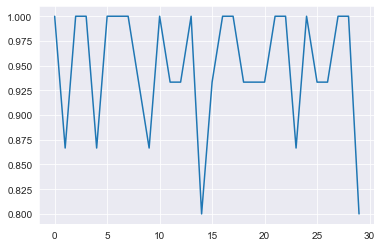

In [69]:
plt.plot(scores)

Preliminary model score:
0.9666666666666667


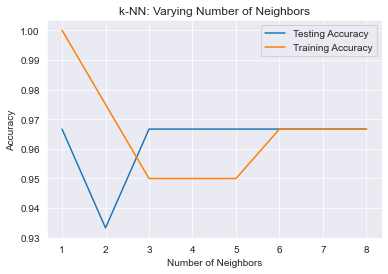

In [70]:
# more complex version so you can create a graph for testing and training accuracy (not built into the previous version)

#Split arrays or matrices into train and test subsets
Xsi_train, Xsi_test, ysi_train, ysi_test = train_test_split(X_si, y_si, test_size=0.20) 
rcv_knn = KNeighborsClassifier(n_neighbors=6)
rcv_knn.fit(Xsi_train, ysi_train)

print("Preliminary model score:")
print(rcv_knn.score(Xsi_test, ysi_test))

no_neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    rcv_knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    rcv_knn.fit(Xsi_train, ysi_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = rcv_knn.score(Xsi_train, ysi_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = rcv_knn.score(Xsi_test, ysi_test)

# Visualization of k values vs accuracy
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Variable importance

There is no easy way in SKLearn to calculate variable importance for a KNN model. So, we'll use a slightly hacked-together solution.

Variable importance reflects the significance one variable has on the model. If a variable is more important, that variable being removed/permuted has a larger effect on the output of the model. So, if we check the changes such permutations have, we should be able to extract the feature importance.

In [71]:
data = {'sepal_length': [0], 'sepal_width': [0], 'petal_length': [0], 'petal_width': [0]}
feat_imp = pd.DataFrame(data)
feat_imp.head()

sepal_length  sepal_width  petal_length  petal_width
0             0            0             0            0

0.9666666666666667


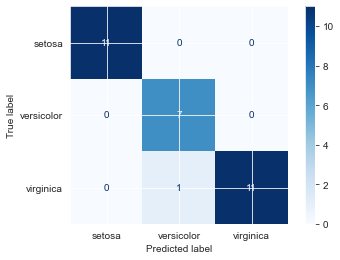

In [72]:
# baseline

fin_knn = KNeighborsClassifier(n_neighbors=7)
fin_knn.fit(Xsi_train, ysi_train)

print(fin_knn.score(Xsi_test, ysi_test))
plot_confusion_matrix(fin_knn, Xsi_test, ysi_test, cmap='Blues')  

#### change `Sepal.Length`

In [73]:
Xsi_test.head()

Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
144      1.159173     0.328414      1.217458     1.448832
149      0.432165     0.788808      0.933271     1.448832
56      -0.173674    -0.592373      0.421734     0.132510
5       -1.021849     1.249201     -1.340227    -1.315444
27      -1.021849     0.788808     -1.226552    -1.052180

In [74]:
perm_SL = Xsi_test.copy()   # # copy df; we don't want to alter the actual data
perm_SL['Sepal.Length'] = np.random.permutation(perm_SL['Sepal.Length'])   # permute data
perm_SL.head()

Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
144     -0.900681     0.328414      1.217458     1.448832
149     -1.021849     0.788808      0.933271     1.448832
56      -0.900681    -0.592373      0.421734     0.132510
5        2.128516     1.249201     -1.340227    -1.315444
27       0.189830     0.788808     -1.226552    -1.052180

In [75]:
fin_knn.score(perm_SL, ysi_test)

0.9

In [76]:
feat_imp['sepal_length'] = fin_knn.score(Xsi_test, ysi_test) - fin_knn.score(perm_SL, ysi_test)
feat_imp.head()

sepal_length  sepal_width  petal_length  petal_width
0      0.066667            0             0            0

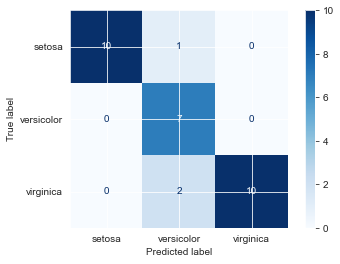

In [77]:
plot_confusion_matrix(fin_knn, perm_SL, ysi_test, cmap='Blues')  # what got misclassified?

Instead of making this repetitive, we can turn this into a function and loop.

In [90]:
def featureImportance(X, y, model):
    # create dataframe of variables
    var_imp = pd.DataFrame(columns=list(X.columns))
    var_imp.loc[0] = 0
    base_score = model.score(X, y)
    for col in list(X.columns):
        temp = X.copy()   # # copy df; we don't want to alter the actual data
        temp[col] = np.random.permutation(temp[col])   # permute data
        var_imp[col] = base_score - model.score(temp, y)
        # plot_confusion_matrix(model, temp, y, cmap='Blues')  # what got misclassified?
    print(var_imp)

In [91]:
featureImportance(Xsi_test, ysi_test, fin_knn)

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
0      0.033333          0.0           0.4     0.266667


From here, we find the important variables!

### General eval

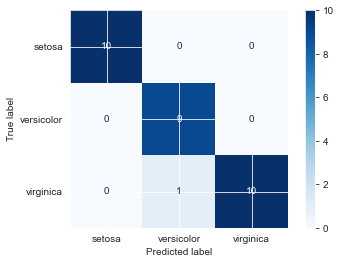

In [324]:
plot_confusion_matrix(fin_knn, Xsi_test, ysi_test, cmap='Blues')  

Looks like we only misclassified one virginica as versicolor. Let's see how certain our predictions were.

In [326]:
iris2_probs = fin_knn.predict_proba(Xsi_test)
iris2_probs

array([[0.        , 0.14285714, 0.85714286],
       [0.        , 0.28571429, 0.71428571],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.85714286, 0.14285714],
       [0.        , 1.        , 0.        ],
       [0.        , 0.28571429, 0.71428571],
       [0.        , 0.14285714, 0.85714286],
       [0.        , 0.28571429, 0.71428571],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.42857143, 0.57142857],
       [0.        , 0.71428571, 0.28571429],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.85714286, 0.14285714],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.